# Credit Card Fraud Detection

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
pd.options.display.max_columns = 100

## Data Understanding

### Exploratory Data Analysis

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


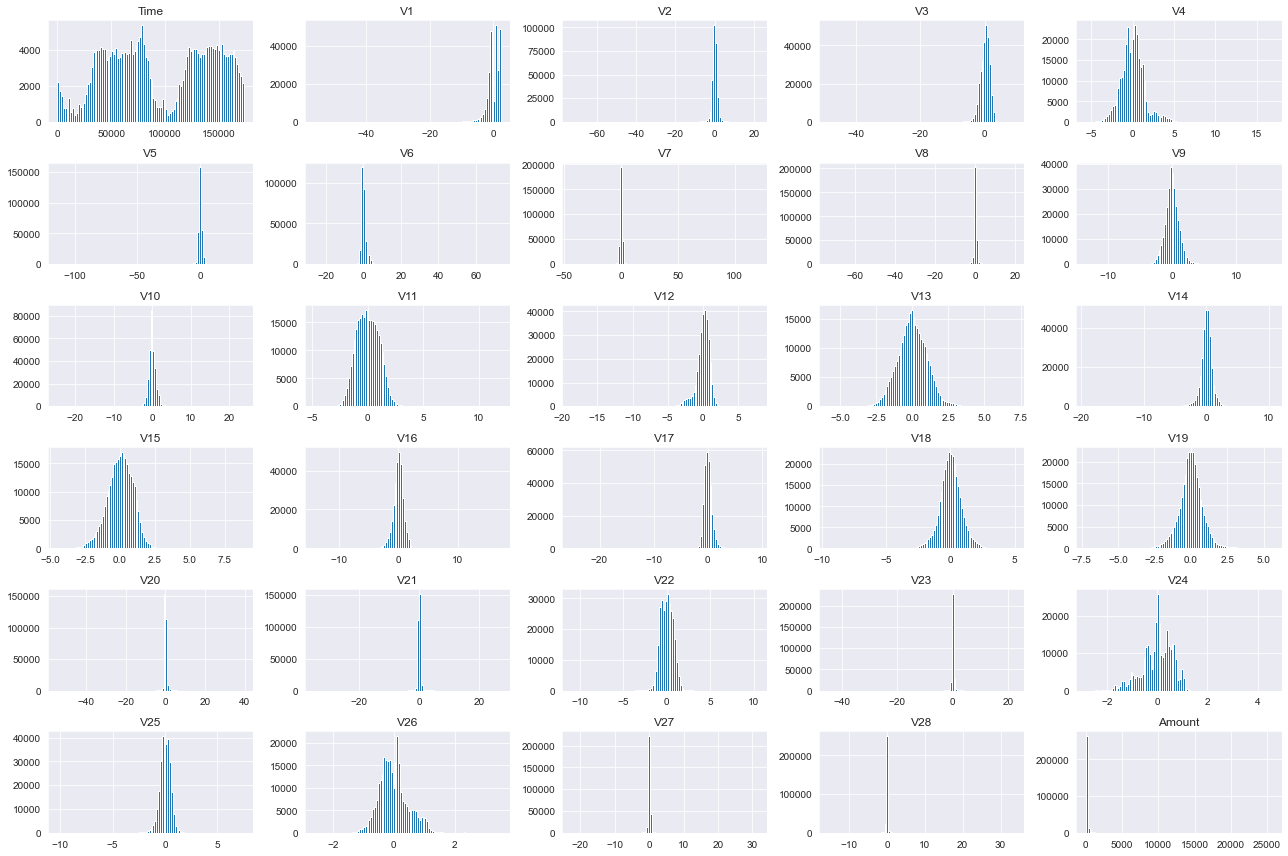

In [4]:
fig, axes = plt.subplots(6,5, figsize=(18,12))
for ax, c in zip(axes.flat, df.columns):
    ax.hist(df[c], bins=100)
    ax.set_title(c)
plt.tight_layout()
#plt.savefig('images/overall.jpg')

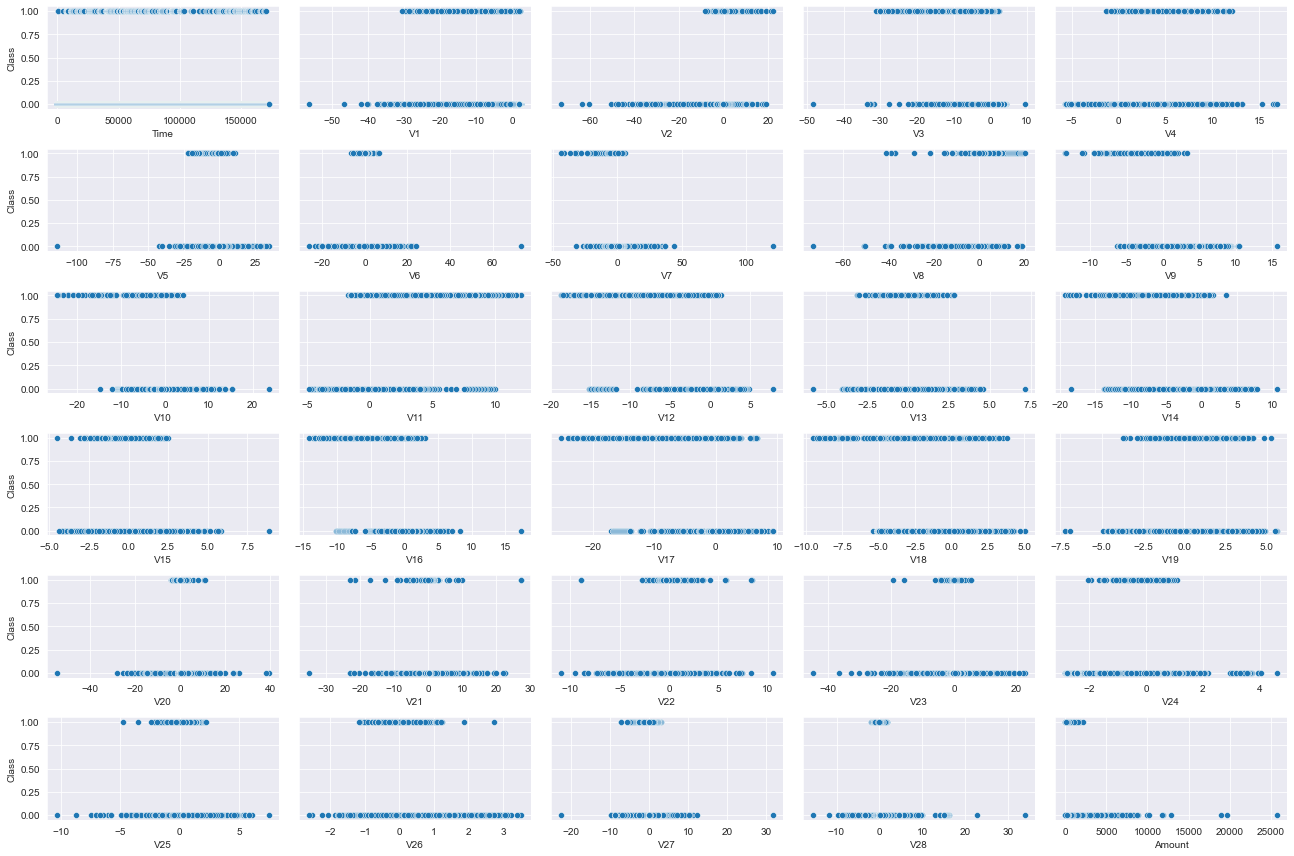

In [5]:
fig, axes = plt.subplots(6,5, sharey=True, figsize=(18,12))
for ax, c in zip(axes.flat, df.columns):
    sns.scatterplot(data=df, x=c, y='Class', ax=ax)
plt.tight_layout()
#plt.savefig('images/class.jpg')

## Data Obfuscation & Evaluation

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, auc, roc_curve
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

### Data Split

hold out data

In [7]:
X = df.drop(['Time','Class'], axis=1)
y = df.Class

# hold out data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

### Differential Privacy for Input

In [8]:
# logistic regression and grid search

def LogReg(X_train, X_test, y_train, y_test):
    # grid search
    param_grid = {'fit_intercept': [True, False],    
                  'C': [1e16],
                  'solver': ['lbfgs','liblinear','saga']}

    grid_lr = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, n_jobs=-1)
    grid_lr.fit(X_train, y_train)

    train_pred_lr = grid_lr.predict(X_train)
    test_pred_lr = grid_lr.predict(X_test)

    # metric evaluation
    y_score = grid_lr.decision_function(X_test)
    fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_score)
    
    return train_pred_lr, test_pred_lr, fpr_lr, tpr_lr

In [13]:
# Laplace mechanism for input data
epsilon = 1
_, _, fpr_lr_e1, tpr_lr_e1 = LogReg(X_train+np.random.laplace(loc=0, scale=1/epsilon), X_test, y_train, y_test)

epsilon = 0.1
_, _, fpr_lr_e01, tpr_lr_e01 = LogReg(X_train+np.random.laplace(loc=0, scale=1/epsilon), X_test, y_train, y_test)
        
print('AUC with eplsilon = 1: {}'.format(auc(fpr_lr_e1, tpr_lr_e1)))
print('AUC with eplsilon = 0.1: {}'.format(auc(fpr_lr_e01, tpr_lr_e01)))

AUC with eplsilon = 1: 0.9752941535790344
AUC with eplsilon = 0.1: 0.9753546826251096


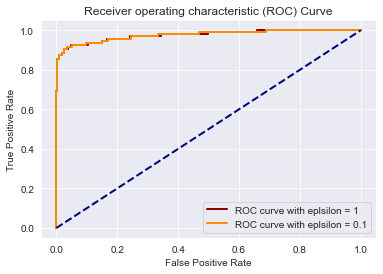

In [15]:
plt.plot(fpr_lr_e1, tpr_lr_e1, lw=2, color='darkred', label='ROC curve with eplsilon = 1')
plt.plot(fpr_lr_e01, tpr_lr_e01, lw=2, color='darkorange', label='ROC curve with eplsilon = 0.1')
plt.plot([0, 1], [0, 1], c='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('Receiver operating characteristic (ROC) Curve')
#plt.savefig('images/roc_input.jpg')

### Differential Privacy for Ouput

To protect the patients from honestly answering 'yes' or 'no' to this question related to cancer, a randomized procedure is initiated as follows:

1. We set up a threshold (m) first. If a random number < m, petients have to answer honestly.
2. If a random number > m, we set another random number to compare with the threshold again, i.e. yes for < m and no for > m.

The true ratio of the patients the cancer is p_true, and the observed ratio with noise is p_noise. Their mathematical relationship is 

$$p_{noise} = m*p_{true} + 0.5*(1-m)$$
$$p_{true} = \frac{p_{noise}}{m} - \frac{0.5*(1-m)}{m}$$

The noise (m) can be added by taking numbers from Laplacian or Gaussian distribution.

In [16]:
p_true = y.sum()/len(y)
p_true_train = y_train.sum()/len(y_train)
p_true_test = y_test.sum()/len(y_test)

In [17]:
p_true,p_true_train,p_true_test

(0.001727485630620034, 0.0017424126050604577, 0.001667778519012675)

In [18]:
# add noise
m = 0.999
condlist = [np.random.uniform(size=len(y_train)) < m, np.random.uniform(size=len(y_train)) < 0.5]
choicelist = [y_train, y_train]
y_noise = np.select(condlist, choicelist,  1-y_train)

In [19]:
# logistic regression

train_pred_lr, test_pred_lr, fpr_lr, tpr_lr = LogReg(X_train, X_test, y_noise, y_test)

p_train_noise_lr = train_pred_lr.sum()/len(train_pred_lr)
p_test_noise_lr = test_pred_lr.sum()/len(test_pred_lr)

print('Training probability of cancer by logistic regression: {}'.format(p_train_noise_lr/m-0.5*(1-m)/m))
print('Testing probability of cancer  by logistic regression: {}'.format(p_test_noise_lr/m-0.5*(1-m)/m))
print('AUC with noise by logistic regression: {}'.format(auc(fpr_lr, tpr_lr)))

Training probability of cancer by logistic regression: 0.0006900951731867483
Testing probability of cancer  by logistic regression: 0.0006593265081379961
AUC with noise by logistic regression: 0.9776005508698504


In [21]:
# Xgboost

grid_xgb = GridSearchCV(estimator=XGBClassifier(), param_grid={}, n_jobs=-1)
grid_xgb.fit(X_train, y_noise)

train_pred_xgb = grid_xgb.predict(X_train)
test_pred_xgb = grid_xgb.predict(X_test)

p_train_noise_xgb = train_pred_xgb.sum()/len(train_pred_xgb)
p_test_noise_xgb = test_pred_xgb.sum()/len(test_pred_xgb)

y_score = grid_xgb.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test, y_score)

print('Training probability of cancer by Xgboost: {}'.format(p_train_noise_xgb/m-0.5*(1-m)/m))
print('Testing probability of cancer by Xgboost: {}'.format(p_test_noise_xgb/m-0.5*(1-m)/m))
print('AUC with noise by Xgboost: {}'.format(auc(fpr_xgb, tpr_xgb)))

Training probability of cancer by Xgboost: 0.0016698104323463665
Testing probability of cancer by Xgboost: 0.0009404966920503589
AUC with noise by Xgboost: 0.9650832552039709


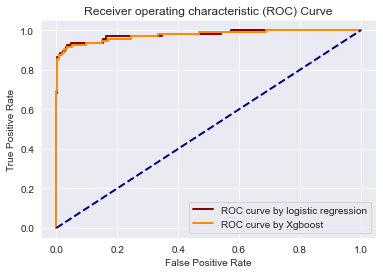

In [23]:
plt.plot(fpr_lr, tpr_lr, lw=2, color='darkred', label='ROC curve by logistic regression')
plt.plot(fpr_lr_e01, tpr_lr_e01, lw=2, color='darkorange', label='ROC curve by Xgboost')
plt.plot([0, 1], [0, 1], c='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('Receiver operating characteristic (ROC) Curve')
#plt.savefig('images/roc_output.jpg')